In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from natsort import natsorted
from datetime import datetime
import math

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pdb

In [119]:
#preprocessing of data 
#@Adian

Raw_data_distance=pd.read_csv("C:\\Users\\Administrator\\Desktop\\CLASSDATA\\Earth-Moon Distance in 2022.csv",encoding='utf-8')
Row_data_tides_file=os.listdir("C:\\Users\\Administrator\\Desktop\\2022TIdesData")
Row_data_tides_file=natsorted(Row_data_tides_file)

#Preparation
All_data_tides_time=[]
All_data_tides_level=[]
x=0
for i in(Row_data_tides_file):
    read_csv=pd.read_csv("C:\\Users\\Administrator\\Desktop\\2022TIdesData\\"+i)
    read_csv_1=read_csv['Date'].copy()
    read_csv_1.to_string()
    read_csv_2=read_csv['Time (GMT)'].copy()
    read_csv_3=(read_csv_1+' '+read_csv_2).astype('datetime64')
    All_data_tides_time.append(read_csv_3)
    All_data_tides_level.append(read_csv['Verified (ft)'])
    x+=1
All_data_tides_time=pd.concat(All_data_tides_time)
All_data_tides_level=pd.concat(All_data_tides_level)

All_data_distance_pre=[]
for i in (Raw_data_distance.values):
    All_data_distance_pre.extend(i)

All_data_distance=[]
for a in(All_data_distance_pre):
    value=a/100000
    All_data_distance.append(value)
All_data_distance = [x for x in All_data_distance if math.isnan(x) == False]

In [117]:
time = []
days31 = {1,3,5,7,8,10,12}
days30 = {4,6,9,11}
def incre(i,daynum):
    if i <10:
        for j in range(1,daynum):
            if j<10:
                a=('2022-0{0}-0{1}'.format(i,j))
                time.append(a)
            else:
                a=('2022-0{0}-{1}'.format(i,j))
                time.append(a)
    else:
        for j in range(1,daynum):
            if j<10:
                a=('2022-{0}-0{1}'.format(i,j))
                time.append(a)
            else:
                a=('2022-{0}-{1}'.format(i,j))
                time.append(a)

for mon in range(1,13):
    if mon in days31:
        incre(mon,32)
    elif mon in days30:
        incre(mon,31)
    else:
        incre(2,29)
All_data_tides_time

0      2022-01-01 00:00:00
1      2022-01-01 00:06:00
2      2022-01-01 00:12:00
3      2022-01-01 00:18:00
4      2022-01-01 00:24:00
               ...        
7435   2022-12-31 23:30:00
7436   2022-12-31 23:36:00
7437   2022-12-31 23:42:00
7438   2022-12-31 23:48:00
7439   2022-12-31 23:54:00
Length: 87600, dtype: datetime64[ns]

In [34]:
#All_data_tides_time 十二个月的waterlevel时间
#All_data_tides_level 十二个月的waterlevel
#All_data_distance 十二个月的地月距离
#time 地月距离的时间轴

14:41:27 - cmdstanpy - INFO - Chain [1] start processing
14:41:28 - cmdstanpy - INFO - Chain [1] done processing


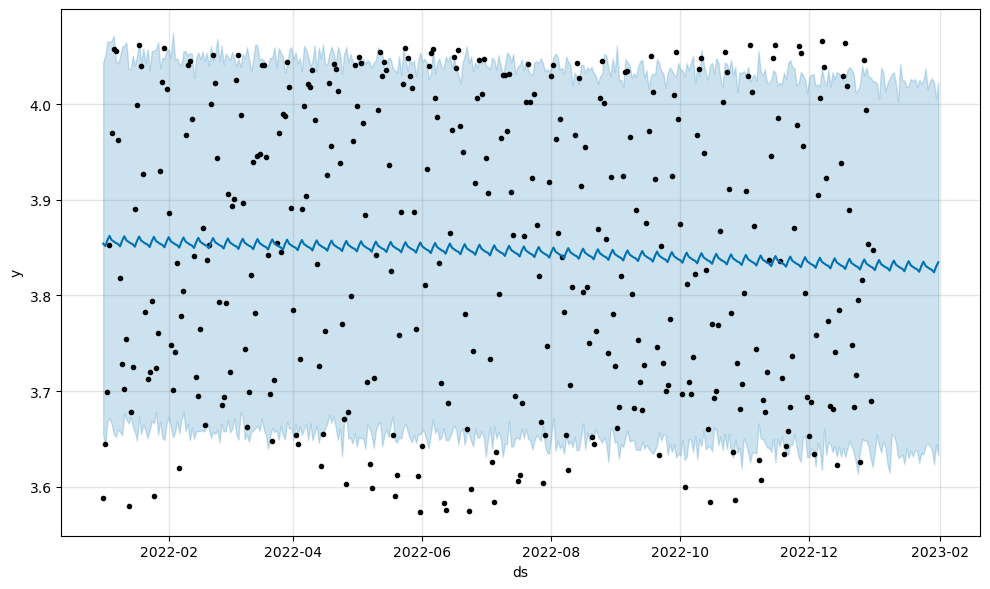

In [122]:
p = Prophet(changepoint_prior_scale=0.01)
pro_df = pd.DataFrame()
pro_df['y'] = All_data_distance
pro_df['ds'] = time
p.fit(pro_df)
future = p.make_future_dataframe(periods= 31)
forcast = p.predict(future)
p.plot(forcast)
plt.show()

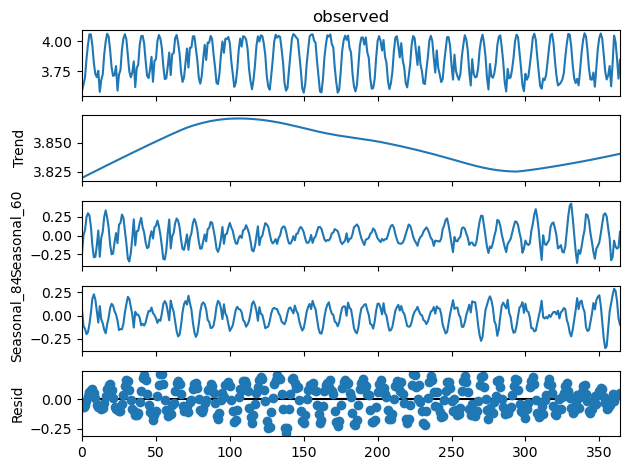

In [123]:
mstl = MSTL(pro_df["y"], 
            periods=[60,7*12],
            iterate=12, 
            stl_kwargs=
            {"seasonal_deg": 12,
             "inner_iter": 12, 
             "outer_iter": 0})
res = mstl.fit() 
ax = res.plot()
plt.tight_layout()

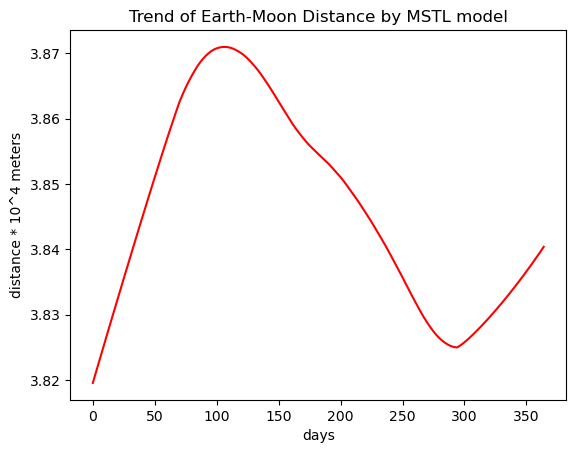

In [124]:
#data analysis : 地月距离变化的趋势
plt.plot(res.trend,c='r')
plt.title("Trend of Earth-Moon Distance by MSTL model")
plt.xlabel("days")
plt.ylabel("distance * 10^4 meters")
plt.show()

In [117]:
All_data_tides_level

0       2.82
1       2.80
2       2.82
3       2.77
4       2.73
        ... 
7435    1.59
7436    1.53
7437    1.60
7438    1.58
7439    1.50
Name: Verified (ft), Length: 87600, dtype: float64

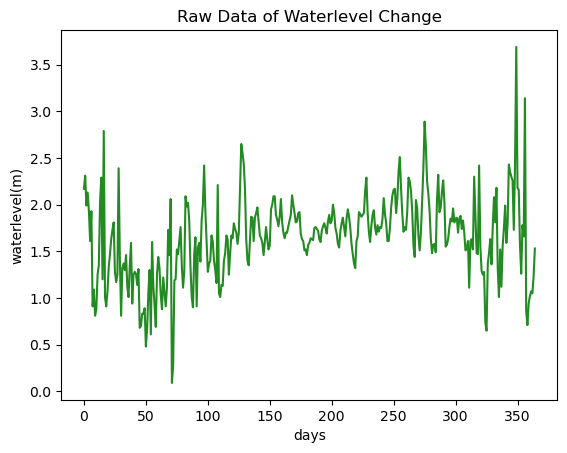

In [104]:
#data analysis : 潮汐强度变化的趋势
davg = []
tidesdata_days = []
j = 0
for i in time:
    s = 0
    cnt = 0
    while All_data_tides_time.iloc[j].strftime("%Y-%m-%d") == i:
        s += All_data_tides_level.iloc[j]
        cnt+=1
        j +=1
        if j == 87600: break
    davg.append(round(s/cnt,2))
plt.plot(np.arange(0,365),davg,c='forestgreen')
plt.xlabel('days')
plt.ylabel('waterlevel(m)')
plt.title('Raw Data of Waterlevel Change')
plt.show()

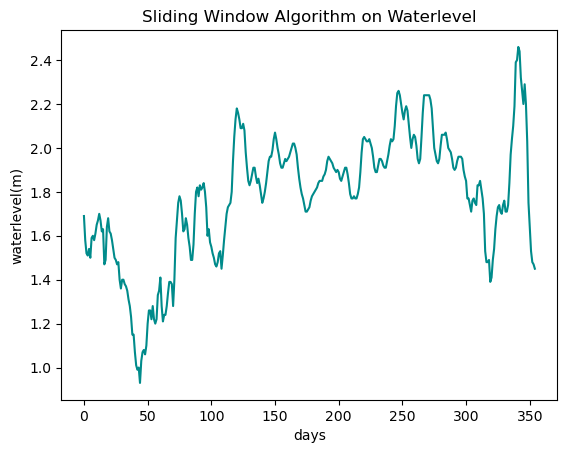

In [105]:
#data anlysis: moving window algorithm 
ytrend = []
ws=10
sp = 0
ep = sp+ws
tempsum = 0
for i in range(ep):
    tempsum += davg[i]
endsum = round(tempsum/ws,2)
ytrend.append(endsum)
while ep < 364:
    ep+=1
    sp+=1
    tempsum = tempsum+davg[ep]-davg[sp]
    endsum = round(tempsum/ws,2)
    ytrend.append(endsum)
plt.plot(np.arange(0,len(ytrend)),ytrend,c='darkcyan')
plt.xlabel('days')
plt.ylabel('waterlevel(m)')
plt.title('Sliding Window Algorithm on Waterlevel')
plt.show()

In [112]:
pindex = np.polyfit(np.arange(0,len(ytrend)),ytrend,5)
pindex

array([-6.18652957e-12,  6.40579954e-09, -2.43586111e-06,  3.96205156e-04,
       -2.17919529e-02,  1.71229747e+00])

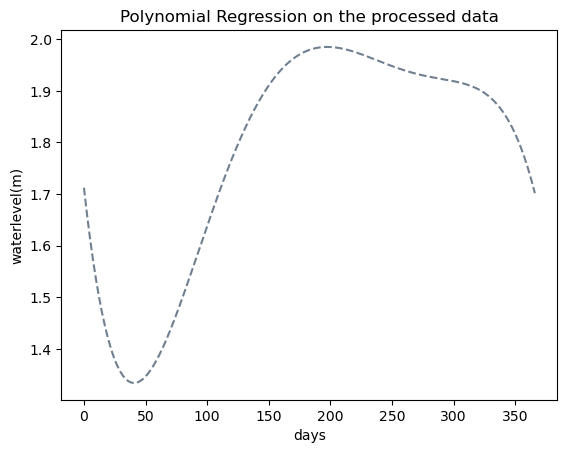

In [113]:
xp = np.linspace(0,366,300)
p = np.poly1d(pindex)
plt.plot(xp,p(xp),'--',c='slategray')
plt.xlabel('days')
plt.ylabel('waterlevel(m)')
plt.title('Polynomial Regression on the processed data')
plt.show()

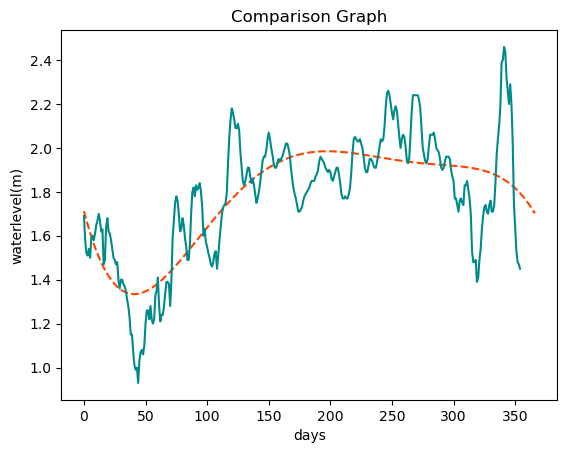

In [114]:
xp = np.linspace(0,366,300)
p = np.poly1d(pindex)
plt.plot(xp,p(xp),'--',c='orangered',label='Regression Line')
plt.plot(np.arange(0,len(ytrend)),ytrend,c='darkcyan',label='Sliding Window Line')
plt.xlabel('days')
plt.ylabel('waterlevel(m)')
plt.title('Comparison Graph')
plt.show()

In [103]:
p2index = np.polyfit(np.arange(0,365),davg,6)
p2index

array([ 6.59413816e-14, -8.21475094e-11,  3.99047441e-08, -9.51268035e-06,
        1.12773792e-03, -5.51884089e-02,  2.05028974e+00])

In [229]:
comp_trend = (res.trend-3.05)*15-10.6


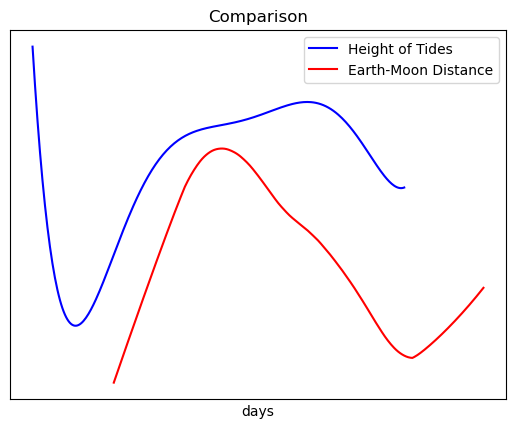

In [241]:
xp2 = np.linspace(0,366,300)
p2 = np.poly1d(p2index)
plt.plot(xp2,p2(xp2),c ='b',label = 'Height of Tides')
plt.plot(np.arange(0,365)+80,comp_trend,c='r', label = 'Earth-Moon Distance')
plt.legend()
plt.grid()
plt.title("Comparison")
ax = plt.gca()
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticks([])
plt.xlabel("days")
plt.show()

In [126]:
#prediction
pre_tides_df = pd.DataFrame()
pre_tides_df['y'] = davg
pre_tides_df['ds'] = time
pr = Prophet()
pr.fit(pre_tides_df)
future = pr.make_future_dataframe(periods= 31)
forcast = pr.predict(future)
pr.plot(forcast)
plt.xlabel('days')
plt.ylabel('waterlevel(m)')
plt.title('Prophet Prediction on Waterlevel(m)')
plt.show()
forcast

TypeError: DataFrame.__init__() got an unexpected keyword argument 'changepoint'

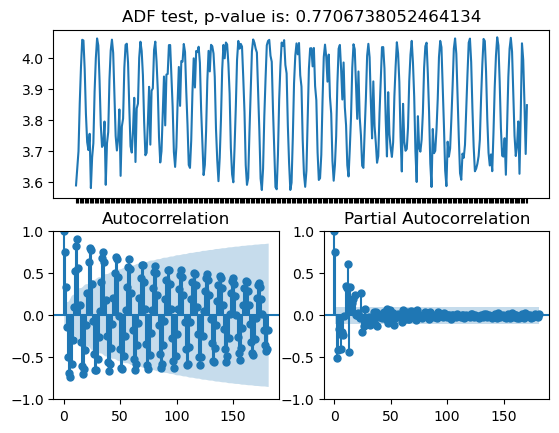

In [21]:
#initializing df
emd_df = pd.DataFrame()
emd_df['time'] = time
emd_df['values'] = All_data_distance
emd_df = emd_df.set_index('time')

#ADF test
#p value is bigger that 0.05,meaning it is unsatble
def plot(df):
    results = adfuller(df)
    results_str = 'ADF test, p-value is: {}'.format(results[1])

    grid = plt.GridSpec(2, 2)
    ax1 = plt.subplot(grid[0, :])
    ax2 = plt.subplot(grid[1, 0])
    ax3 = plt.subplot(grid[1, 1])

    ax1.plot(df)
    ax1.set_title(results_str)
    ax1.set_xticklabels(pd.date_range('2022-01-01','2022-12-31',0))
    plot_acf(df, lags=int(len(df) / 2 - 1), ax=ax2)
    plot_pacf(df, lags=int(len(df) / 2 - 1), ax=ax3)
    plt.show()

plot(emd_df)

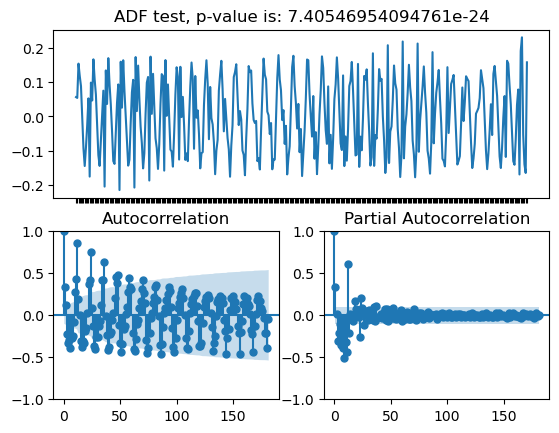

        lb_stat      lb_pvalue
6    195.332020   1.868704e-39
12   629.509255  5.265182e-127
24  1181.221552  2.467796e-234


In [50]:
#stablize
#apply first difference on the series
decomposition = STL(emd_df['values'],period=12).fit()
#decomposition.plot()
#plt.xticks(pd.date_range('2022-01-01','2022-12-31',0))
emd_diff = emd_df - emd_df.shift(1)
emd_diff = emd_diff.dropna()
plot(emd_diff)

#white noise testing/Ljung-Box Test(LB)
#p value is always smaller than 0.05, it is not a white noise series
res = acorr_ljungbox(emd_diff, lags=[6,12,24], return_df=True)
print(res)

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  291
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 12)   Log Likelihood                1614.263
Date:                              Thu, 03 Aug 2023   AIC                          -3210.526
Time:                                      13:00:40   BIC                          -3177.845
Sample:                                  01-02-2022   HQIC                         -3197.417
                                       - 10-19-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.952e-06   2.94e-05     -0.236      0.813   -6.46e-05    5.07e-05
ar.L1          0.88

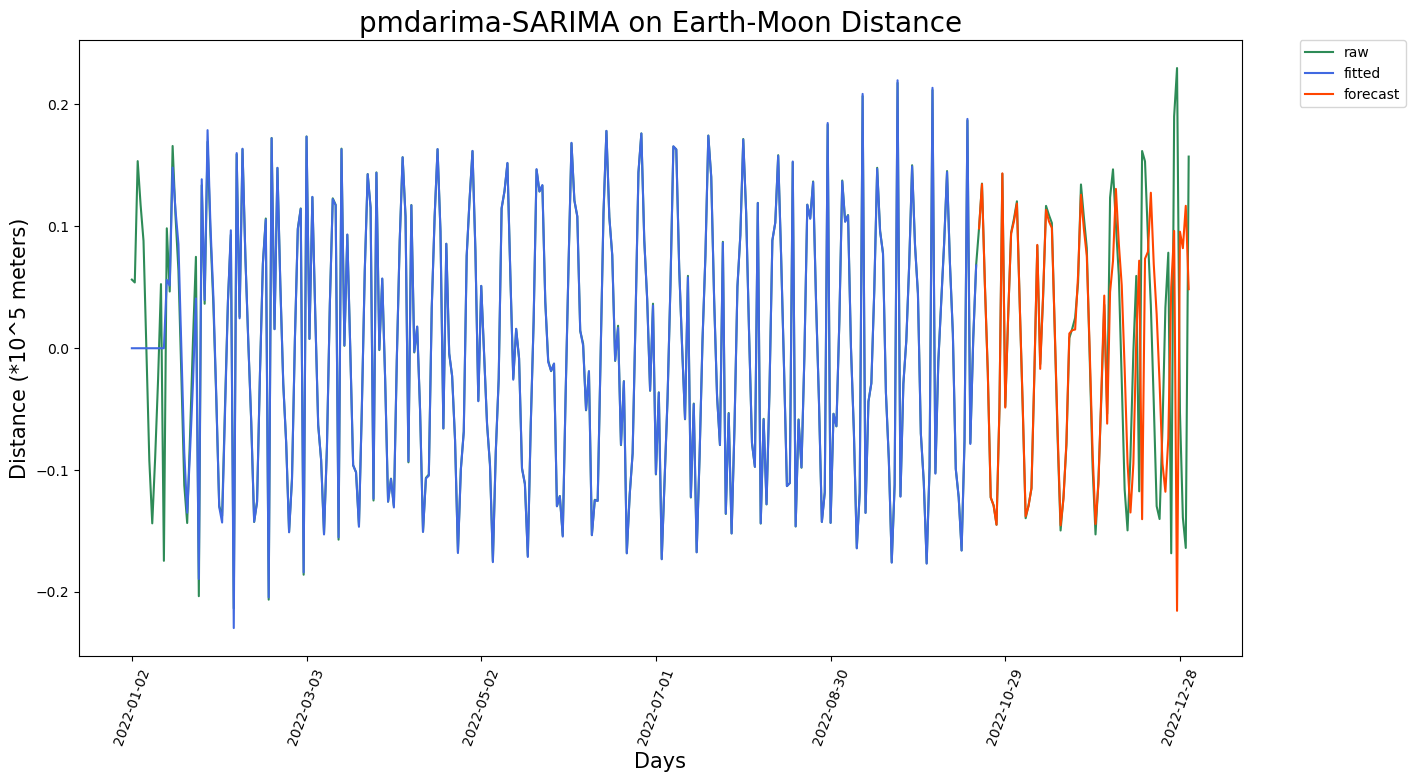

In [69]:
#automatically finds the hyper parameters for the model
def sarima_with_pmdarima(df):
    """
    Auto-SARIMA（pmdarima）
    """
    #determining the number of periods
    periods = 12

    #separates 80% data for training and 20% of data for testing    
    train, test = train_test_split(df, train_size=0.8)

    # model training 
    model = pm.auto_arima(train, seasonal=True, m=periods)
    print(model.summary())

    # fitting results
    fitted = model.predict_in_sample()
    fitted = pd.Series(fitted, index=train.index)

    # Prediction
    fcst = model.predict(test.shape[0])
    fcst = pd.Series(fcst, index=test.index)

    # Estimation by MSE
    mse = np.sqrt(mean_squared_error(test, fcst))
    print('RMSE: %.4f' % mse)

    # Visualizing Model and Prediction
    plt.figure(figsize=(15, 8))
    plt.plot(df,label='raw',c='seagreen')
    plt.plot(fitted,label = 'fitted',c='royalblue')
    plt.plot(fcst,label = 'forecast',c='orangered')
    plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0)
    plt.title('pmdarima-SARIMA on Earth-Moon Distance',fontsize = 20)
    plt.xlabel('Days',fontsize = 15)
    plt.ylabel('Distance (*10^5 meters)',fontsize = 15)
    plt.xticks(rotation = 70,fontsize = 10)
    plt.yticks(fontsize = 10)
    xl = plt.MultipleLocator(60)
    ax = plt.gca()
    ax.xaxis.set_major_locator(xl)
    plt.show()
    
sarima_with_pmdarima(emd_diff)

In [91]:
#######
len(davg)

365

In [92]:
#auto-sarima on waterlevel data
tide_df = pd.DataFrame()
tide_df['time'] = time
tide_df['values'] = davg
tide_df = tide_df.set_index('time')
tide_df

,values
time,
2022-01-01,2.17
2022-01-02,2.31
2022-01-03,1.99
2022-01-04,2.13
2022-01-05,1.93
...,...
2022-12-27,1.02
2022-12-28,1.07
2022-12-29,1.05


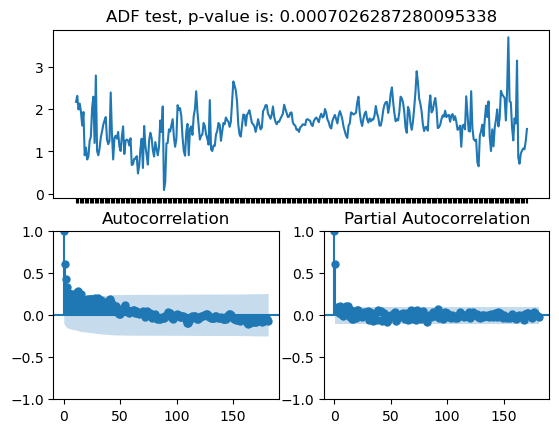

       lb_stat      lb_pvalue
6   320.636818   3.082862e-66
12  443.191548   2.634328e-87
24  629.810107  1.357324e-117


In [94]:
# stable data with p value smaller than 0.05
plot(tide_df)

#white noise testing/Ljung-Box Test(LB)
#p value is always smaller than 0.05, it is not a white noise series
tide_diff = tide_df
res = acorr_ljungbox(tide_diff, lags=[6,12,24], return_df=True)
print(res)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  292
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                 -68.304
Date:                             Thu, 03 Aug 2023   AIC                            144.607
Time:                                     13:38:04   BIC                            159.301
Sample:                                 01-01-2022   HQIC                           150.494
                                      - 10-19-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4869      0.047     10.356      0.000       0.395       0.579
ma.L1         -0.9446      

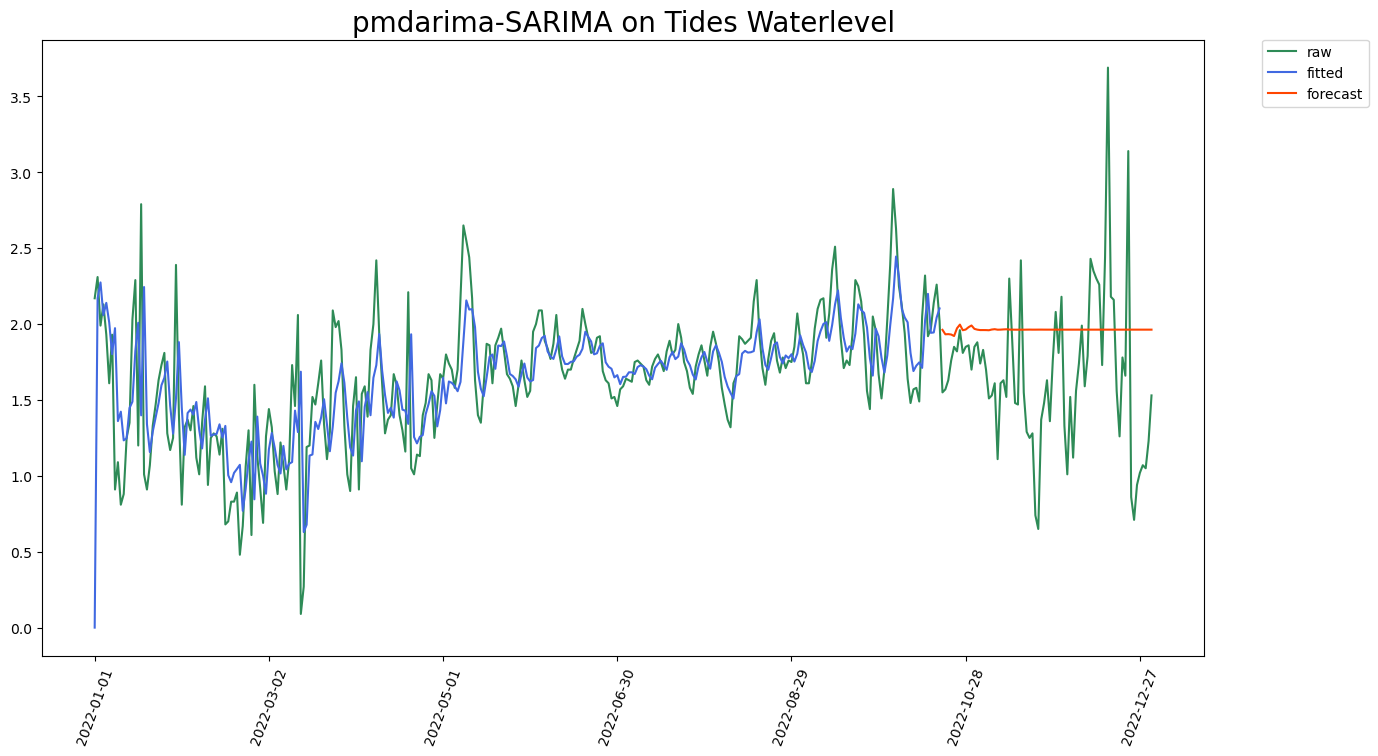

In [96]:
#automatically finds the hyper parameters for the model
def sarima_with_pmdarima(df):
    """
    Auto-SARIMA（pmdarima）
    """
    #determining the number of periods
    periods = 12

    #separates 80% data for training and 20% of data for testing    
    train, test = train_test_split(df, train_size=0.8)

    # model training 
    model = pm.auto_arima(train, seasonal=True, m=periods)
    print(model.summary())

    # fitting results
    fitted = model.predict_in_sample()
    fitted = pd.Series(fitted, index=train.index)

    # Prediction
    fcst = model.predict(test.shape[0])
    fcst = pd.Series(fcst, index=test.index)

    # Estimation by MSE
    mse = np.sqrt(mean_squared_error(test, fcst))
    print('RMSE: %.4f' % mse)

    # Visualizing Model and Prediction
    plt.figure(figsize=(15, 8))
    plt.plot(df,label='raw',c='seagreen')
    plt.plot(fitted,label = 'fitted',c='royalblue')
    plt.plot(fcst,label = 'forecast',c='orangered')
    plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0)
    plt.title('pmdarima-SARIMA on Tides Waterlevel',fontsize = 20)
    
    plt.xticks(rotation = 70,fontsize = 10)
    plt.yticks(fontsize = 10)
    xl = plt.MultipleLocator(60)
    ax = plt.gca()
    ax.xaxis.set_major_locator(xl)
    plt.show()
    
sarima_with_pmdarima(tide_diff)
#arima model should not be applied on this 

([], [])

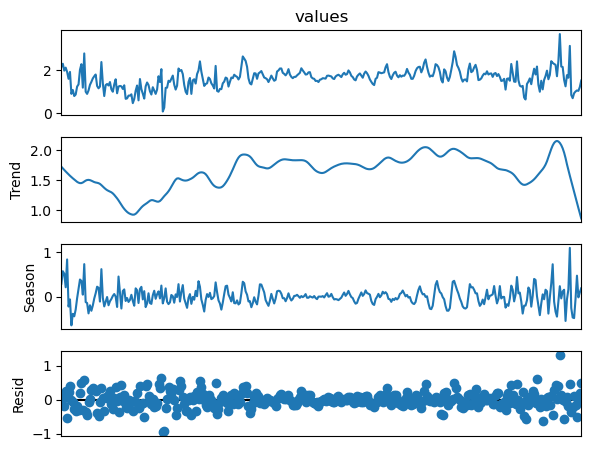

In [97]:
#stablize
#apply first difference on the series
decomposition = STL(tide_df['values'],period=12).fit()
decomposition.plot()
plt.xticks(pd.date_range('2022-01-01','2022-12-31',0))
